In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv("household_power_consumption.txt", sep=";", na_values="?")
print(df.head())
print(df.info())

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782844 entries, 0 to 782843
Data columns (total 9

In [2]:
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df.drop(["Date", "Time"], axis=1, inplace=True)
df = df.apply(pd.to_numeric, errors="coerce")
df.fillna(df.mean(), inplace=True)
print(df.isnull().sum().sum())

0


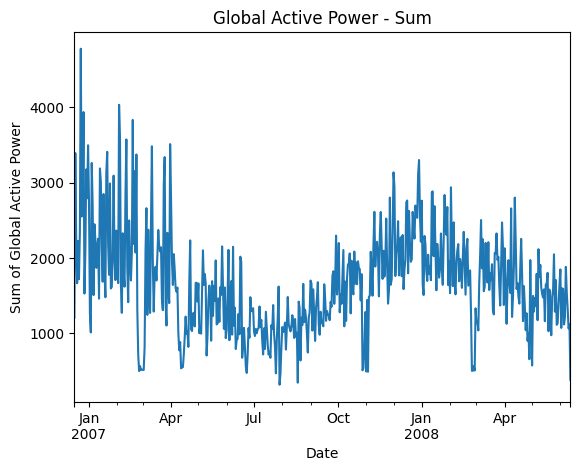

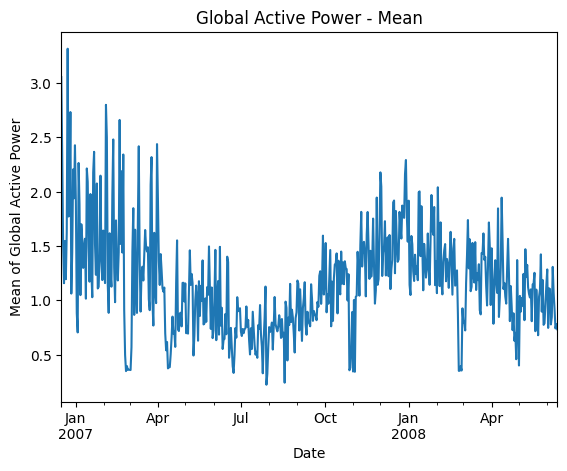

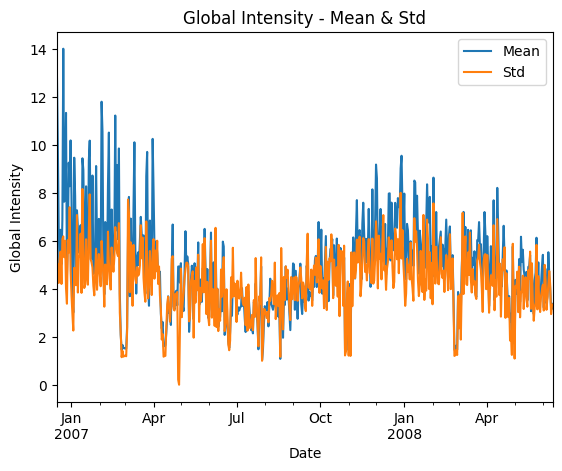

In [3]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)

df["Global_active_power"].resample("D").sum().plot(title="Global Active Power - Sum")
plt.xlabel("Date")
plt.ylabel("Sum of Global Active Power")
plt.show()

df["Global_active_power"].resample("D").mean().plot(title="Global Active Power - Mean")
plt.xlabel("Date")
plt.ylabel("Mean of Global Active Power")
plt.show()

df["Global_intensity"].resample("D").mean().plot(label="Mean", legend=True)
df["Global_intensity"].resample("D").std().plot(label="Std", legend=True)
plt.title("Global Intensity - Mean & Std")
plt.xlabel("Date")
plt.ylabel("Global Intensity")
plt.show()

In [4]:
target_col = "Global_active_power"
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

X = df_scaled.drop(columns=[target_col]).values
y = df_scaled[target_col].values

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

batch_size = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        return self.fc(lstm_out[:, -1, :])

input_size = X_train.shape[1]
model = LSTMModel(input_size)

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    y_pred = model(X_test_t)
    r2 = r2_score(y_test.squeeze(), y_pred.numpy().squeeze())

print(f"R² Score: {r2:.4f}")

Epoch 1/10, Loss: 0.0000
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
R² Score: 0.9988
